In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(stringr))
library(viridis)
library(scales)
library(RColorBrewer)
library(parallel)
library(purrr)
library(ggplot2)
library(igraph)
library(ggraph)
library(coin)
library(colormap)
library(rstatix)
library(corrplot)
library(GGally)
options(warn=-1)

mid_rescaler <- function(mid = 0) {
  function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
    scales::rescale_mid(x, to, from, mid)
  }
}
cor.mtest <- function(mat, conf.level = 0.95) {
  mat <- as.matrix(mat)
  n <- ncol(mat)
  p.mat <- matrix(NA, n, n)
  diag(p.mat) <- 0
  for (i in 1:(n - 1)) {
    for (j in (i + 1):n) {
      tmp <- cor.test(mat[, i], mat[, j], 
                      method='spearman',
                      conf.level = conf.level)
      p.mat[i, j] <- p.mat[j, i] <- tmp$p.value
    }
  }
  colnames(p.mat) <- rownames(p.mat) <- colnames(mat)
  p.mat
}

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal



Attaching package: ‘purrr’


The following object is masked from ‘package:scales’:

    discard



Attaching package: ‘igraph’


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tibble’:

    as_data_frame


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: survival


Attaching package: ‘coin’


The following object is masked from ‘package:scales’:

    pvalue



Attaching package: ‘rstatix’


The following objects are masked from ‘package:coin’:

    chisq_test, friedman_test, kruskal_test,

In [2]:
T_cell_data<-read.csv("01_Get_Metrics/BRI_Tcell_data_forcorrelation.csv")
T_cell_data<-T_cell_data[,-1]
B_cell_data<-read.csv("01_Get_Metrics/BRI_Bcell_data_forcorrelation.csv",check.names = FALSE)
B_cell_data<-B_cell_data[,-1]


In [3]:
new_colnames <- names(T_cell_data)
new_colnames[2:length(new_colnames)] <- str_c("T_", new_colnames[2:length(new_colnames)])
names(T_cell_data) <- new_colnames

new_colnames <- names(B_cell_data)
new_colnames[2:length(new_colnames)] <- str_c("B_", new_colnames[2:length(new_colnames)])
names(B_cell_data) <- new_colnames

In [4]:
combined_df<-left_join(T_cell_data,B_cell_data)

Joining with `by = join_by(subject.subjectGuid)`


In [5]:

combined_df<-combined_df[ , -which(names(combined_df) %in% 
                                   c('B_CoreMemoryB_HALLMARK_MYC_TARGETS_V2',
                                     #'B_CoreMemoryB_Freq_Fold_Changes',
                                     'B_CoreMemoryB_HALLMARK_ALLOGRAFT_REJECTION',
                                     'B_CoreMemoryB_HALLMARK_MTORC1_SIGNALING',
                                     #'B_MSD_phuket_fold_change',
                                     'T_flow_Tfh_PD1pos_mean_diff',
                                     'T_flow_Tfh_PD1neg_mean_diff'))]

In [6]:
meta_data<-read.csv("/home/jupyter/BRI_Figures_Final_V2/Figure5/01_Frequency_Comparison/selected_samples_with_acutal_flu_year.csv")

In [7]:
meta_data$Ages<-meta_data$subject.birthYear


In [8]:
combined_df<-left_join(combined_df,unique(meta_data[c('subject.subjectGuid','Ages')]))

Joining with `by = join_by(subject.subjectGuid)`


In [9]:
combined_df<-combined_df %>% filter(T_NMF_Th2<0.1)

In [10]:
colnames(combined_df)

[1] "subject.subjectGuid"                           
 [2] "T_NMF_Th2"                                     
 [3] "T_NMF_Tfh"                                     
 [4] "T_Down_composite_score_sum_scaled_mean"        
 [5] "T_Up_composite_score_sum_scaled_mean"          
 [6] "T_InteractionScore_CD40LG_CD40"                
 [7] "T_InteractionScore_PTPRC_CD22"                 
 [8] "T_Mean_Expression_CD40LG"                      
 [9] "T_Mean_Expression_CXCR5"                       
[10] "B_CoreMemoryB_HALLMARK_TNFA_SIGNALING_VIA_NFKB"
[11] "B_CoreMemoryB_HALLMARK_PI3K_AKT_MTOR_SIGNALING"
[12] "B_CoreMemoryB_HALLMARK_MYC_TARGETS_V1"         
[13] "B_MSD_phuket_fold_change"                      
[14] "B_HAI_fold_change"                             
[15] "B_Plasma_Freq_Fold_Changes"                    
[16] "B_CoreMemoryB_Freq_Fold_Changes"               
[17] "B_CD95memB_Freq_Fold_Changes"                  
[18] "B_Mean_Expression_IGHG4_CorememB"              
[19] "B_Mean_Expression_IGHG4_CD95memB"              
[20] "B_Mean_Expression_IGHG3_CD27negB"              
[21] "B_Mean_Expression_CD19_CD27negB"               
[22] "Ages"

In [11]:
spearman_test(T_NMF_Th2 ~ T_Down_composite_score_sum_scaled_mean, data = combined_df)
spearman_test(T_NMF_Th2 ~ T_Up_composite_score_sum_scaled_mean, data = combined_df)
spearman_test(T_NMF_Tfh ~ T_Down_composite_score_sum_scaled_mean, data = combined_df)
spearman_test(T_NMF_Tfh ~ T_Up_composite_score_sum_scaled_mean, data = combined_df)
spearman_test(T_Mean_Expression_CXCR5 ~ B_CoreMemoryB_HALLMARK_TNFA_SIGNALING_VIA_NFKB, data = combined_df)



	Asymptotic Spearman Correlation Test

data:  T_NMF_Th2 by T_Down_composite_score_sum_scaled_mean
Z = -4.0254, p-value = 5.688e-05
alternative hypothesis: true rho is not equal to 0



	Asymptotic Spearman Correlation Test

data:  T_NMF_Th2 by T_Up_composite_score_sum_scaled_mean
Z = 2.251, p-value = 0.02439
alternative hypothesis: true rho is not equal to 0



	Asymptotic Spearman Correlation Test

data:  T_NMF_Tfh by T_Down_composite_score_sum_scaled_mean
Z = 6.4638, p-value = 1.021e-10
alternative hypothesis: true rho is not equal to 0



	Asymptotic Spearman Correlation Test

data:  T_NMF_Tfh by T_Up_composite_score_sum_scaled_mean
Z = -1.4016, p-value = 0.161
alternative hypothesis: true rho is not equal to 0



	Asymptotic Spearman Correlation Test

data:  T_Mean_Expression_CXCR5 by
	 B_CoreMemoryB_HALLMARK_TNFA_SIGNALING_VIA_NFKB
Z = 2.2896, p-value = 0.02205
alternative hypothesis: true rho is not equal to 0


In [12]:
cor_matrix <- as.data.frame(cor(combined_df[2:dim(combined_df)[2]],method='spearman', use = "pairwise.complete.obs"))
cor_matrix$from<-rownames(cor_matrix)
cor_matrix <- cor_matrix[, c(ncol(cor_matrix), 1:(ncol(cor_matrix)-1))]

# Transform the adjacency matrix in a long format
connect <- as.data.frame(cor_matrix) %>%
  gather(key="to", value="value", -1) %>%
  mutate(to = gsub("\\.", " ",to)) %>%
  na.omit() 

In [13]:
p_matrix <- cor.mtest(combined_df[2:dim(combined_df)[2]])

# Convert p_matrix to data frame and add row names
p_matrix <- as.data.frame(p_matrix)
p_matrix$from <- rownames(p_matrix)
p_matrix <- p_matrix[, c(ncol(p_matrix), 1:(ncol(p_matrix)-1))]

# Transform the adjacency matrix in a long format
connect <- as.data.frame(cor_matrix) %>% 
  gather(key="to", value="cor_value", -1) %>%
  mutate(to = gsub("\\.", " ",to)) %>%
  na.omit()

# Transform p_matrix to long format
p_values_long <- as.data.frame(p_matrix) %>%
  gather(key="to", value="p_value", -1) %>%
  mutate(to = gsub("\\.", " ",to)) %>%
  na.omit()

In [14]:
connect$p_value<-p_values_long$p_value

In [15]:
write.csv(connect,"connect_all.csv")

In [16]:
connect<-connect %>% filter(from%in% c('T_NMF_Tfh','T_NMF_Th2'))


In [17]:
write.csv(connect,"connect.csv")

In [18]:
#connect <- connect %>% filter(p_value < 0.01)
connect<-connect %>% filter(from%in% c('T_NMF_Tfh','T_NMF_Th2'))
connect <- connect %>% filter(p_value < 0.05)

In [19]:
gap_mock<-data.frame( from = "T_NMF_Th2",
                     to = "Mock",
                     cor_value = 1,
                     p_value=1)

In [20]:
connect<-rbind(connect,gap_mock)

In [21]:
connect

from,to,cor_value,p_value
<chr>,<chr>,<dbl>,<dbl>
T_NMF_Th2,T_NMF_Th2,1.0000000,0.000000e+00
T_NMF_Tfh,T_NMF_Th2,-0.3267220,7.202220e-03
T_NMF_Th2,T_NMF_Tfh,-0.3267220,7.202220e-03
T_NMF_Tfh,T_NMF_Tfh,1.0000000,0.000000e+00
T_NMF_Th2,T_Down_composite_score_sum_scaled_mean,-0.4954905,2.592940e-05
T_NMF_Tfh,T_Down_composite_score_sum_scaled_mean,0.7956341,0.000000e+00
T_NMF_Th2,T_Up_composite_score_sum_scaled_mean,0.2770772,2.351549e-02
T_NMF_Th2,T_InteractionScore_CD40LG_CD40,-0.2687833,2.785464e-02
T_NMF_Th2,T_InteractionScore_PTPRC_CD22,-0.5201289,6.446608e-06


In [22]:
replacements <- c("T_NMF_Th2" = "CM CD4 T-Th2 Scores",
                  "T_NMF_Tfh" = "CM CD4 T-Tfh Scores",
                  
                  "Mock" = "Mock",
                  
                  "Ages" = "Biological Ages",
                  "T_Down_composite_score_sum_scaled_mean" = "CM CD4 T-Age Composite Metric(Down)",
                  "T_Up_composite_score_sum_scaled_mean" = "CM CD4 T-Age Composite Metric(Up)",
                  
                  "T_InteractionScore_CD40LG_CD40" = "CM CD4 T/Core memory B-CD40LG_CD40 Interaction Score",
                  "T_InteractionScore_PTPRC_CD22" = "CM CD4 T/Core memory B-PTPRC_CD22 Interaction Score",
                  "T_Mean_Expression_CD40LG" = "CM CD4 T-CD40LG Mean Expression",
                  "T_Mean_Expression_CXCR5" = "CM CD4 T-CXCR5 Mean Expression",
                  
                  "B_CoreMemoryB_HALLMARK_TNFA_SIGNALING_VIA_NFKB" = "Core memory B-TNFA SIGNALING VIA NFKB Pathway Score",
                  "B_CoreMemoryB_HALLMARK_PI3K_AKT_MTOR_SIGNALING" = "Core memory B-PI3K AKT MTOR SIGNALING Pathway Score",
                  "B_CoreMemoryB_HALLMARK_MYC_TARGETS_V1" = "Core memory B-MYC TARGETS V1 Pathway Score",
                  "B_Mean_Expression_CD19" = "CD27 effector B-CD19 Mean Expression",
                  "B_Mean_Expression_IGHG4_CorememB" = "Core memory B-IGHG4 Mean Expression",
                  "B_Mean_Expression_IGHG4_CD95memB" = "CD95 memory B-IGHG4 Mean Expression",
                  "B_HAI_phuket_day7" = "HAI Assay-Day 7 Inhibition",
                  "B_HAI_fold_change"= "HAI Assay-Day 7/0 Fold Change",

                  "B_Plasma_Freq_Fold_Changes" = "Plasma Cell-Day7/Day0 Frequency(CLR) Changes"
             
                 )

In [23]:
connect <- connect %>%
  mutate(to = if_else(to %in% names(replacements), replacements[to], to))
connect_addon<-connect %>% filter(from=='T_NMF_Th2',to=="CM CD4 T-Tfh Scores")
connect_addon$to<-"T_NMF_Tfh"

connect<-connect %>% filter(!to %in%c("CM CD4 T-Tfh Scores","CM CD4 T-Th2 Scores") )

connect<-rbind(connect,connect_addon)

In [24]:
options(repr.plot.width = 5, repr.plot.height = 6)
# Number of connection per person
c( as.character(connect$from), as.character(connect$to)) %>%
  as.tibble() %>%
  group_by(value) %>%
  summarize(n=n()) -> coauth
colnames(coauth) <- c("name", "n")
#dim(coauth)

# Create a graph object with igraph
mygraph <- graph_from_data_frame( connect, vertices = coauth, directed = FALSE )

# Find community
com <- walktrap.community(mygraph)
#max(com$membership)
#Reorder dataset and make the graph
coauth <- coauth %>% 
  mutate( grp = com$membership) %>%
  mutate(name = if_else(name %in% names(name), replacements[name], name))



In [25]:
coauth$name<-factor(coauth$name,levels=c(c("T_NMF_Tfh","T_NMF_Th2"),replacements))
coauth<-coauth %>%  arrange(name)

In [26]:

coauth <- coauth %>%
  mutate(cat = case_when(
    str_starts(name, 'Core') ~ "B cell",
    str_starts(name, 'CM CD4 T') ~ "T cell", 
    str_starts(name, 'CM CD4 T-Tfh') ~ "Cell States", 
    str_starts(name, 'CM CD4 T-Th2') ~ "Cell States", 
    TRUE ~ 'Others'
  ))
# Create a graph object with igraph
mygraph <- graph_from_data_frame( connect, vertices = coauth, directed = FALSE )

# prepare a vector of n color in the viridis scale
mycolor <- colormap(colormap=colormaps$viridis, nshades=max(coauth$grp))
mycolor <- sample(mycolor, length(mycolor))

In [27]:
diverging_palette <- colorRampPalette(c('#67001F', '#B2182B', 
                                            '#D6604D', '#F4A582', 
                                            '#FDDBC7', '#FFFFFF',
                                            '#D1E5F0', '#92C5DE', 
                                            '#4393C3', '#2166AC', 
                                            '#053061'))(500)

In [28]:
connect<-connect %>% arrange(from,to)

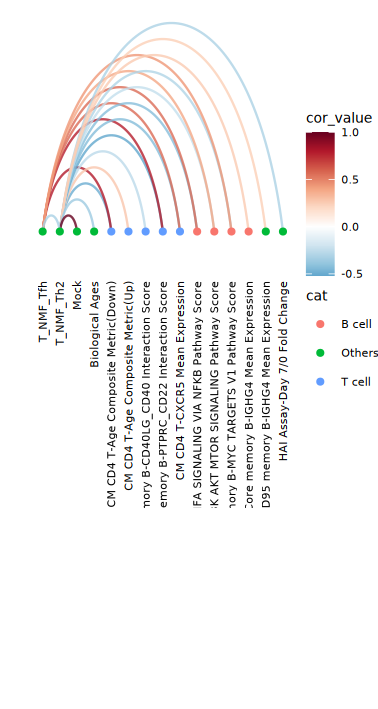

In [95]:
options(repr.plot.width = 80/25.4, repr.plot.height = 150/25.4)

p<-ggraph(mygraph, layout="linear") + 
  geom_edge_arc(aes(colour = cor_value),angle_calc='cross', strength =  0.8, 
                edge_alpha=0.8, edge_width=0.5) +
  geom_node_point(aes( color=cat),size=2,stroke=0) +
  scale_edge_color_gradientn(colors = rev(diverging_palette) ,
                             rescaler = ~ scales::rescale_mid(.x, mid = -0)) +
  geom_node_text(aes(label=name), 
               angle=90, hjust=1, 
               nudge_y = -1.1, 
               size=2.3) +
  theme_void(base_size=8) +
  theme(
    plot.margin=unit(c(0,0,0.4,0), "null"),
    panel.spacing=unit(c(0,0,3.4,0), "null")
  ) +
  expand_limits(x = c(-1.2, 1.2), y = c(-5.6, 1.2))
p
ggsave("FigureA.pdf",width = 80/25.4, height = 80/25.4)